In [115]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import edward as ed
import pandas as pd
from time import time
import tensorflow as tf
from edward.models import Categorical, Normal
from keras.utils import to_categorical

import seaborn as sns
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [2]:
## Sklearn related modules
from sklearn.utils import shuffle, class_weight
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
random_seed = 2018

In [4]:
ed.set_seed(random_seed)

In [117]:
# inspired by http://nipunbatra.github.io/2014/08/latexify/
plt.style.use(['default'])
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 12, # was 10
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

### Import Data

In [7]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None, dtype = np.float32)
df_val= pd.read_csv(val_file, sep=" ", header = None, dtype = np.float32)
df_test= pd.read_csv(test_file, sep=" ", header = None, dtype = np.float32)

features_name =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'label']
df_train.columns = features_name
df_val.columns = features_name
df_test.columns = features_name

df_train_all = df_train.append(df_val)

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [8]:
df = shuffle(df_train_all, random_state = random_seed)
# df_train = shuffle(df_train, random_state = random_seed)
# df_val = shuffle(df_val, random_state = random_seed)
df_test = shuffle(df_test, random_state = random_seed)


### Class Balance

In [9]:
df.label.value_counts()

0.0    1041
1.0     559
Name: label, dtype: int64

In [10]:
df_major = df[df.label == 0]
df_minor = df[df.label == 1]

In [11]:
df_minor.shape[0]

559

In [12]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = df_major.shape[0], random_state = 2018)

In [13]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [14]:
df_minor_upsmapled.label.value_counts()

0.0    1041
1.0    1041
Name: label, dtype: int64

### Fetaure Scaling

In [15]:
mms = StandardScaler()
train_scale = mms.fit(df_minor_upsmapled.drop('label', axis=1))

xtrain = train_scale.transform(df_minor_upsmapled.drop('label', axis=1))
ytrain =  np.array(df_minor_upsmapled['label'].values)
ytrain = ytrain.reshape(ytrain.shape[0], 1)

xtest = train_scale.transform(df_test.drop('label', axis=1))
ytest = np.array(df_test['label'].values)
ytest = ytest.reshape(ytest.shape[0], 1)

In [16]:
np.shape(xtrain)

(2082, 8)

### Model prior weights

In [17]:
## Hyperparameters
N = np.shape(xtrain)[0]
in_size = np.shape(xtrain)[1]
out_size = 1
l1 = 12 # Number of neurons in the first layer
BATCH_SIZE = 32

In [18]:
def neural_network(X, W_0, W_1, b_0, b_1):
    hidden1 = tf.nn.relu(tf.matmul(X, W_0) + b_0)
    output = tf.nn.sigmoid(tf.matmul(hidden1, W_1) + b_1)
    return output

### Model Prior beliefs

In [134]:
with tf.name_scope('model_prior'):
    
    W_0 = Normal(loc = tf.zeros([in_size, l1], name="weights/loc_w_0"), 
                 scale=tf.ones([in_size, l1], name="weights/scale_w_0"),
                 name  = 'weight_w_0')
    W_1 = Normal(loc=tf.zeros([l1, out_size], name="weights/loc_w_1"), 
                 scale=tf.ones([l1, out_size], name="weights/scale_w_1"),
                 name  = 'weight_w_1')
    b_0 = Normal(loc=tf.zeros(l1, name="weights/loc_b_0"), 
                 scale=tf.ones(l1, name="weights/scale_b_0"),
                 name  = 'weight_b_0')
    b_1 = Normal(loc=tf.zeros(out_size, name="weights/loc_b_1"),
                 scale=tf.ones(out_size, name="weights/scale_b_1"),
                 name  = 'weight_b_1')
    
    X = tf.placeholder(tf.float32, shape = (None, in_size)) 
    y = Normal(loc = neural_network(X, W_0, W_1, b_0, b_1), scale = 1.0)   

In [135]:
W_0_val, W_1_val, b_0_val, b_1_val  = W_0.eval(), W_1.eval(), b_0.eval(), b_1.eval()

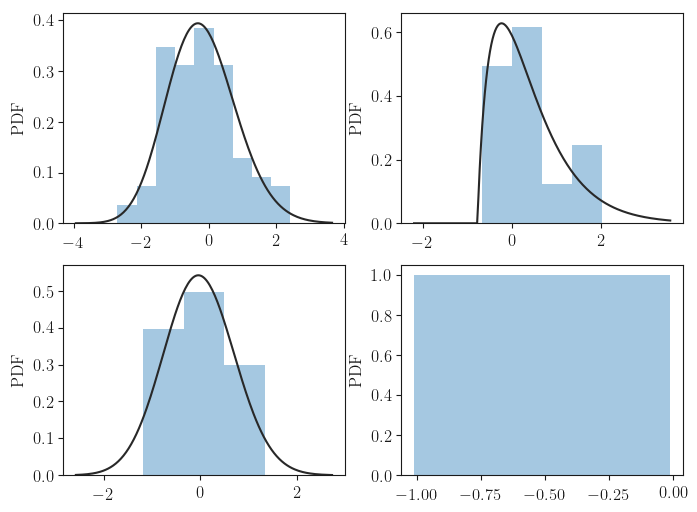

In [141]:
plt.figure(figsize=(8, 6))
plt.subplot(221)
sns.distplot(W_0_val.reshape(-1), kde=False, fit=stats.gamma)
plt.ylabel('PDF')

plt.subplot(222)
sns.distplot(W_1_val.reshape(-1), kde=False, fit=stats.gamma)   
plt.ylabel('PDF')

plt.subplot(223)
sns.distplot(b_0_val.reshape(-1), kde=False, fit=stats.gamma)   
plt.ylabel('PDF')

plt.subplot(224)
sns.distplot(b_1_val.reshape(-1))   
plt.ylabel('PDF')

plt.show()

### Model posterior

In [142]:
with tf.name_scope('posterior'):
    qW_0 = Normal(loc=tf.Variable(tf.random_normal([in_size, l1]), name = "weights/loc_qw_0" ), 
                  scale=tf.Variable(tf.random_normal([in_size, l1]), name = "weights/scale_qw_0"),
                  name = "weight_qw_0")
    
    qW_1 = Normal(loc=tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ), 
                  scale=tf.Variable(tf.random_normal([l1, out_size]), name = "weights/loc_qw_1" ),
                  name = "weight_qw_1")
    
    qb_0 = Normal(loc=tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ), 
                scale=tf.Variable(tf.random_normal([l1]), name = "weights/loc_qb_0" ),
                name = "weight_qb_0")
    qb_1 = Normal(loc=tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ), 
                scale=tf.Variable(tf.random_normal([out_size]), name = "weights/loc_qb_1" ),
                name = "weight_qb_1")

### Inference

In [143]:
with tf.name_scope("inference"):
    
    inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                         W_1: qW_1, b_1: qb_1}, 
                        data={X: xtrain, 
                              y: ytrain})

    global_step = tf.Variable(0, trainable=False, name = "global_step")
    initial_learning_rate = tf.Variable(0.05, trainable = False, name = "initial_learning_rate")

    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               10000, 0.3, staircase=True)

    optimizer = tf.train.AdamOptimizer(learning_rate)

    inference.run(n_iter = 1000, optimizer = optimizer, global_step = global_step, logdir = r'./log')

1000/1000 [100%] ██████████████████████████████ Elapsed: 88s | Loss: 2171.409


### Sampling 

In [144]:
n_samples = 100

qW_0_samples = qW_0.sample(sample_shape=n_samples)
qW_1_samples = qW_1.sample(sample_shape=n_samples)
qb_0_samples = qb_0.sample(sample_shape=n_samples)
qb_1_samples = qb_1.sample(sample_shape=n_samples)

print("Preparing to sample...")

t0 = time()
samplenodes = tf.stack([neural_network(X, qW_0_samples[i], qW_1_samples[i],
                                       qb_0_samples[i], qb_1_samples[i]) 
                        for i in range(n_samples)], axis=0)

print("Took", np.int(time() - t0), "secs.")

print("Sampling...")
t0 = time()
samplepredictions = samplenodes.eval(feed_dict={X: xtest})
print("Took", np.int(time() - t0), "secs.")

Preparing to sample...
Took 1 secs.
Sampling...
Took 7 secs.


In [150]:
np.shape(qW_0_samples.eval().mean(axis = 0))

(8, 12)

In [151]:
qw_0_val, qw_1_val = qW_0_samples.eval().mean(axis = 0), qW_1_samples.eval().mean(axis = 0)
qb_0_val, qb_1_val = qb_0_samples.eval().mean(axis = 0), qb_0_samples.eval().mean(axis = 0)

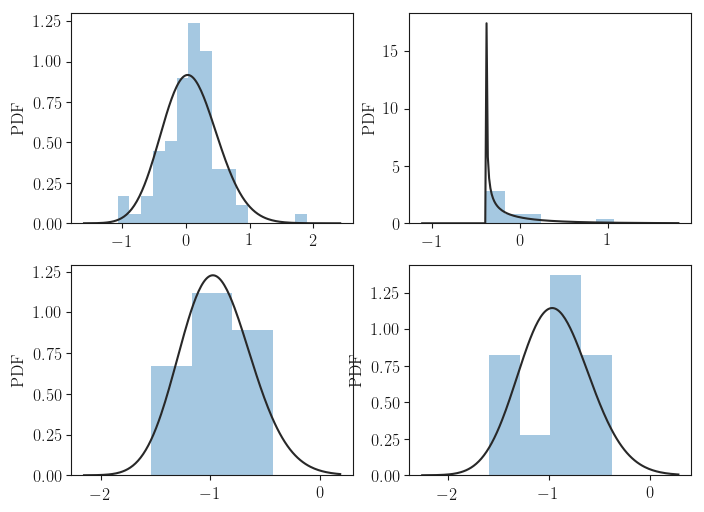

In [152]:
plt.figure(figsize=(8, 6))
plt.subplot(221)
sns.distplot(qw_0_val.reshape(-1), kde=False, fit=stats.gamma)
plt.ylabel('PDF')

plt.subplot(222)
sns.distplot(qw_1_val.reshape(-1), kde=False, fit=stats.gamma)   
plt.ylabel('PDF')

plt.subplot(223)
sns.distplot(qb_0_val.reshape(-1), kde=False, fit=stats.gamma)   
plt.ylabel('PDF')

plt.subplot(224)
sns.distplot(qb_1_val.reshape(-1), kde=False, fit=stats.gamma)   
plt.ylabel('PDF')

plt.show()

In [127]:
predictions_samp = samplepredictions[:, :, 0]

In [128]:
results = pd.DataFrame()
results['target'] = list(ytest)
results.target = results.target.apply(lambda x: int(x[0]))

In [129]:
results['predictions'] = predictions_samp.mean(axis = 0)
results['pred_std'] = predictions_samp.std(axis = 0)
results['pred_var'] = predictions_samp.var(axis = 0)

In [130]:
zzz = stats.norm.interval(0.95, loc = results['predictions'], scale = results['pred_std'])
results['confidence_low'] = np.transpose(zzz)[:, 0]
results['confidence_high'] = np.transpose(zzz)[:, 1]
results['confidence_range'] = np.absolute(results['confidence_high'] - results['confidence_low'])

In [131]:
results['bin_pred'] = results.predictions.apply(lambda x: 1 if x >= 0.5 else 0)

In [132]:
def prediction(ytest, ypred):
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [133]:
prediction(ytest, results['bin_pred'])

Accuracy of the model: 0.7875

Classification report: 
             precision    recall  f1-score   support

        0.0       0.85      0.83      0.84       272
        1.0       0.66      0.69      0.67       128

avg / total       0.79      0.79      0.79       400


Confusion matrix: 
[[227  45]
 [ 40  88]]



In [31]:
results.head(5)

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred
0,0,0.249417,0.148101,0.021934,-0.040855,0.539690,0.580544,0
1,1,0.959836,0.079659,0.006345,0.803708,1.115964,0.312256,1
2,0,0.154619,0.200214,0.040086,-0.237794,0.547032,0.784826,0
3,0,0.268770,0.164340,0.027008,-0.053331,0.590871,0.644202,0
4,1,0.636192,0.257104,0.066102,0.132278,1.140105,1.007827,1
5,0,0.230124,0.150381,0.022615,-0.064619,0.524866,0.589485,0
6,1,0.618998,0.161576,0.026107,0.302316,0.935681,0.633365,1
7,0,0.152876,0.146522,0.021469,-0.134303,0.440054,0.574357,0
8,0,0.278826,0.144137,0.020776,-0.003678,0.561329,0.565007,0
9,0,0.165254,0.168413,0.028363,-0.164830,0.495337,0.660167,0


In [32]:
correct = results[(results.target == results.bin_pred)]

In [33]:
incorrect = results[(results.target != results.bin_pred)]

In [34]:
correct.columns

Index(['target', 'predictions', 'pred_std', 'pred_var', 'confidence_low',
       'confidence_high', 'confidence_range', 'bin_pred'],
      dtype='object')

In [35]:
incorrect.confidence_range[(incorrect.bin_pred == 0)].mean(axis = 0)

0.653657084660075

In [36]:
correct.confidence_range[(correct.bin_pred == 0)].mean(axis = 0)

0.6934292889666662

In [37]:
correct.head(10)

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred
0,0,0.249417,0.148101,0.021934,-0.040855,0.539690,0.580544,0
1,1,0.959836,0.079659,0.006345,0.803708,1.115964,0.312256,1
2,0,0.154619,0.200214,0.040086,-0.237794,0.547032,0.784826,0
3,0,0.268770,0.164340,0.027008,-0.053331,0.590871,0.644202,0
4,1,0.636192,0.257104,0.066102,0.132278,1.140105,1.007827,1
5,0,0.230124,0.150381,0.022615,-0.064619,0.524866,0.589485,0
6,1,0.618998,0.161576,0.026107,0.302316,0.935681,0.633365,1
7,0,0.152876,0.146522,0.021469,-0.134303,0.440054,0.574357,0
8,0,0.278826,0.144137,0.020776,-0.003678,0.561329,0.565007,0
9,0,0.165254,0.168413,0.028363,-0.164830,0.495337,0.660167,0


In [38]:
incorrect.head(10)

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred
11,0,0.628465,0.174499,0.030450,0.286454,0.970476,0.684022,1
23,0,0.617994,0.260332,0.067773,0.107753,1.128235,1.020482,1
36,1,0.364262,0.219257,0.048074,-0.065474,0.793998,0.859472,0
38,0,0.606079,0.274939,0.075591,0.067210,1.144949,1.077739,1
42,0,0.582962,0.281642,0.079322,0.030954,1.134971,1.104018,1
49,1,0.386439,0.173722,0.030179,0.045950,0.726928,0.680977,0
66,1,0.204324,0.179875,0.032355,-0.148225,0.556873,0.705099,0
67,1,0.357077,0.113586,0.012902,0.134451,0.579702,0.445251,0
68,1,0.351623,0.165193,0.027289,0.027852,0.675395,0.647543,0
74,0,0.814679,0.210100,0.044142,0.402890,1.226469,0.823579,1


In [25]:
sns.set(color_codes=True)

def plot_distribution(i):
    xxx = samplepredictions[:, i, 0]
    ax = sns.distplot(xxx, kde=False, fit=stats.gamma)
    ax2 = ax.twinx()
    sns.boxplot(x=xxx, ax=ax2)
    ax2.set(ylim=(-.5, 10))
    plt.show()

/Users/sabber/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


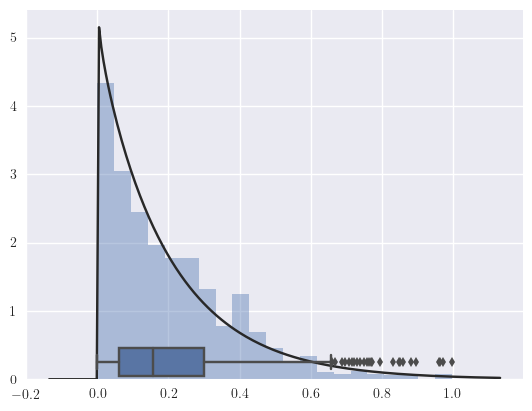

In [39]:
plot_distribution(66)

### Result vizualisation

In [66]:
pca = PCA(n_components = 2, random_state = 2018).fit_transform(xtest)

results['pca_x1'] = pca[:, 0]
results['pca_x2'] = pca[:, 1]

In [120]:
results.head()

,target,predictions,pred_std,pred_var,confidence_low,confidence_high,confidence_range,bin_pred,pca_x1,pca_x2
0,0.0,0.247330,0.098857,0.009773,0.149021,0.345639,0.196618,0,0.557490,-1.138433
1,1.0,0.943311,0.043379,0.001882,0.900172,0.986450,0.086278,1,0.372588,2.210410
2,0.0,0.218576,0.132310,0.017506,0.086999,0.350153,0.263154,0,-2.883425,-0.418066
3,0.0,0.274191,0.124581,0.015520,0.150300,0.398081,0.247781,0,0.412756,-1.462043
4,1.0,0.569014,0.199379,0.039752,0.370741,0.767288,0.396547,1,2.860224,0.236508


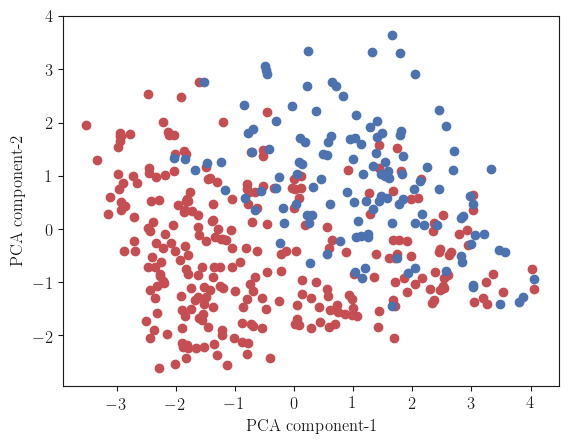

In [124]:
plt.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r')
plt.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b')

plt.xlabel('PCA component-1')
plt.ylabel('PCA component-2')
plt.show()

In [231]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [233]:
print(np.shape(grid), np.shape(grid_2d), np.shape(dummy_out))

(2, 100, 100) (10000, 2) (100,)


In [228]:
from matplotlib.mlab import griddata

xi = np.linspace(-4, 4, 100)
yi = np.linspace(-4, 4, 100)

/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  


Text(0,0.5,'Posterior predictive mean uncertainity')

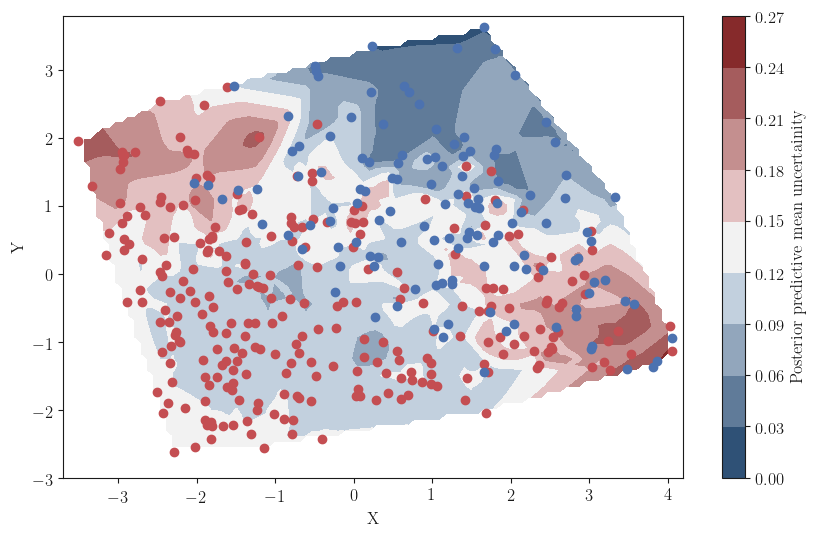

In [230]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.pred_std, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r')
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b')

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean uncertainity')

/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  


Text(0,0.5,'Posterior predictive mean probability')

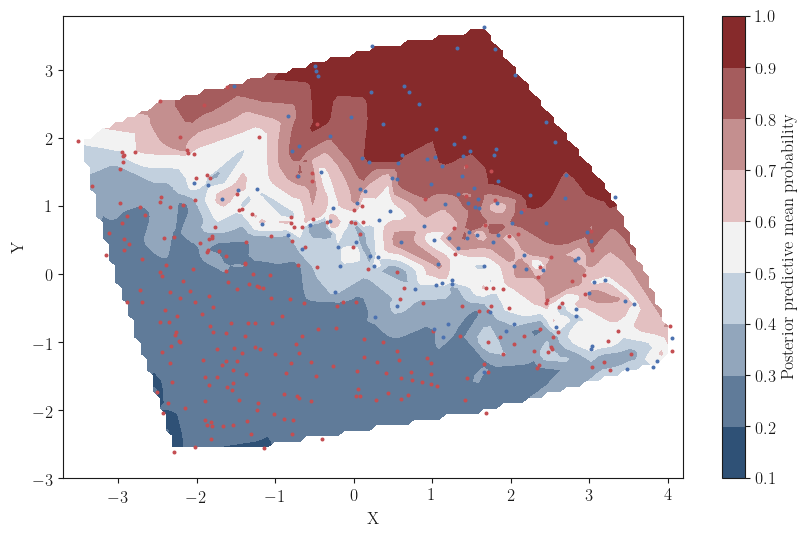

In [177]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.predictions, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 3.5)
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b', s = 3.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean probability')

/Users/sabber/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  


Text(0,0.5,'Posterior predictive mean probability')

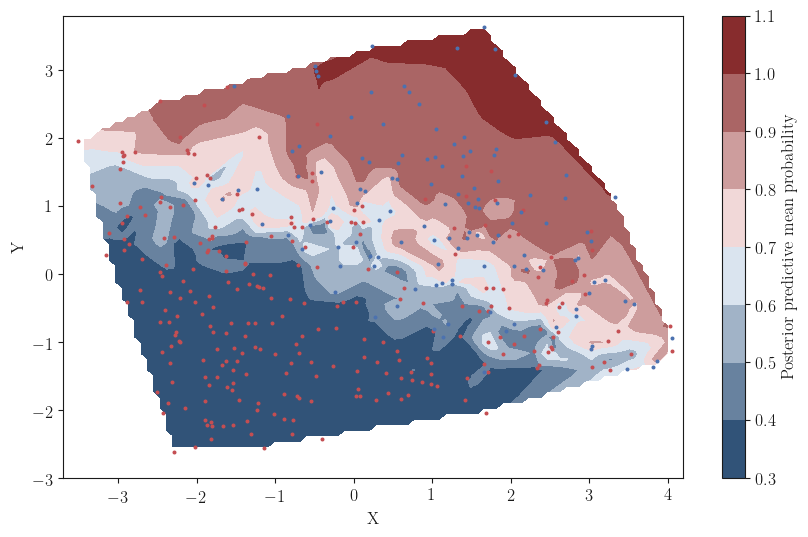

In [182]:
# grid the data.
zi = griddata(results.pca_x1, results.pca_x2, results.confidence_high, xi, yi, interp='linear')

cmap = sns.diverging_palette(250, 12, s = 85, l = 25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(xi, yi, zi, cmap = cmap)
ax.scatter(results.pca_x1[results.target == 0], results.pca_x2[results.target == 0], color = 'r', s = 3.5)
ax.scatter(results.pca_x1[results.target == 1], results.pca_x2[results.target == 1], color = 'b', s = 3.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3.7, 4.2), ylim=(-3, 3.8), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior predictive mean probability')

AttributeError: 'Series' object has no attribute 'reshape'

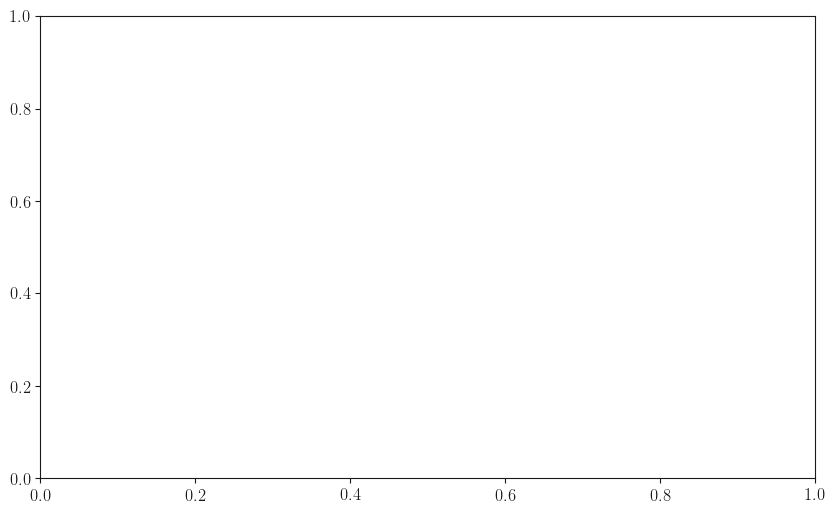

In [103]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(*grid, results.predictions.reshape(100, 100), cmap=cmap)

# ax.scatter(xtest[pred==0, 0], xtest[pred==0, 1])
# ax.scatter(Xtest[pred==1, 0], xtest[pred==1, 1], color='r')

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### CRITICISM

In [ ]:
x_post = ed.copy(x, {p: qp})

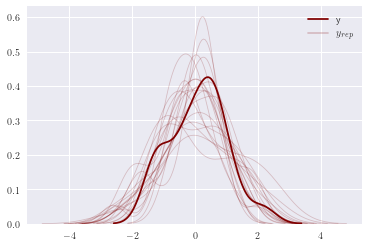

In [191]:
import matplotlib.pyplot as plt

y = np.random.randn(20)
y_rep = np.random.randn(20, 20)

ed.ppc_density_plot(y, y_rep)
plt.show()